In [21]:
import os
from collections import Counter
from datasets import load_from_disk

# Path to the clients_dataset folder
clients_dataset_path = "../src/clients_dataset"

# Dictionary to store dataset info for each client.
# The structure will be:
# {
#     "client_name": {
#         "dataset_name": {
#             "dataset_size": <size>,
#             "label_distribution": <Counter object>
#         },
#         ...
#     },
#     ...
# }
client_data_info = {}


def load_data_info(client_folder):
    """
    Loads each dataset in the client_folder, counts label distribution and stores dataset size.
    """
    distribution_info = {}
    with os.scandir(client_folder) as entries:
        for entry in entries:
            if entry.is_dir():
                dataset_path = entry.path
                data = load_from_disk(dataset_path)
                dataset_size = len(data)
                print(f"Processing {entry.name} (dataset size: {dataset_size})")
                # Count labels efficiently by directly accessing the column.
                label_counts = Counter(data["label"])
                distribution_info[entry.name] = {
                    "dataset_size": dataset_size,
                    "label_distribution": label_counts,
                }
    return distribution_info


# Process each client and store the info.
with os.scandir(clients_dataset_path) as clients:
    for client in clients:
        if client.is_dir():
            print(f"Processing client: {client.name}")
            client_data_info[client.name] = load_data_info(client.path)
            print()  # Blank line for readability

# Now, client_data_info holds both the dataset sizes and label distributions.

Processing client: client_0
Processing clean_train_data (dataset size: 10776)
Processing poisoned_data (dataset size: 7923)
Processing train_data (dataset size: 10776)
Processing val_data (dataset size: 2694)

Processing client: client_1
Processing train_data (dataset size: 11364)
Processing val_data (dataset size: 2841)

Processing client: client_2
Processing train_data (dataset size: 7442)
Processing val_data (dataset size: 1861)

Processing client: client_3
Processing train_data (dataset size: 8884)
Processing val_data (dataset size: 2222)

Processing client: client_4
Processing train_data (dataset size: 9525)
Processing val_data (dataset size: 2382)



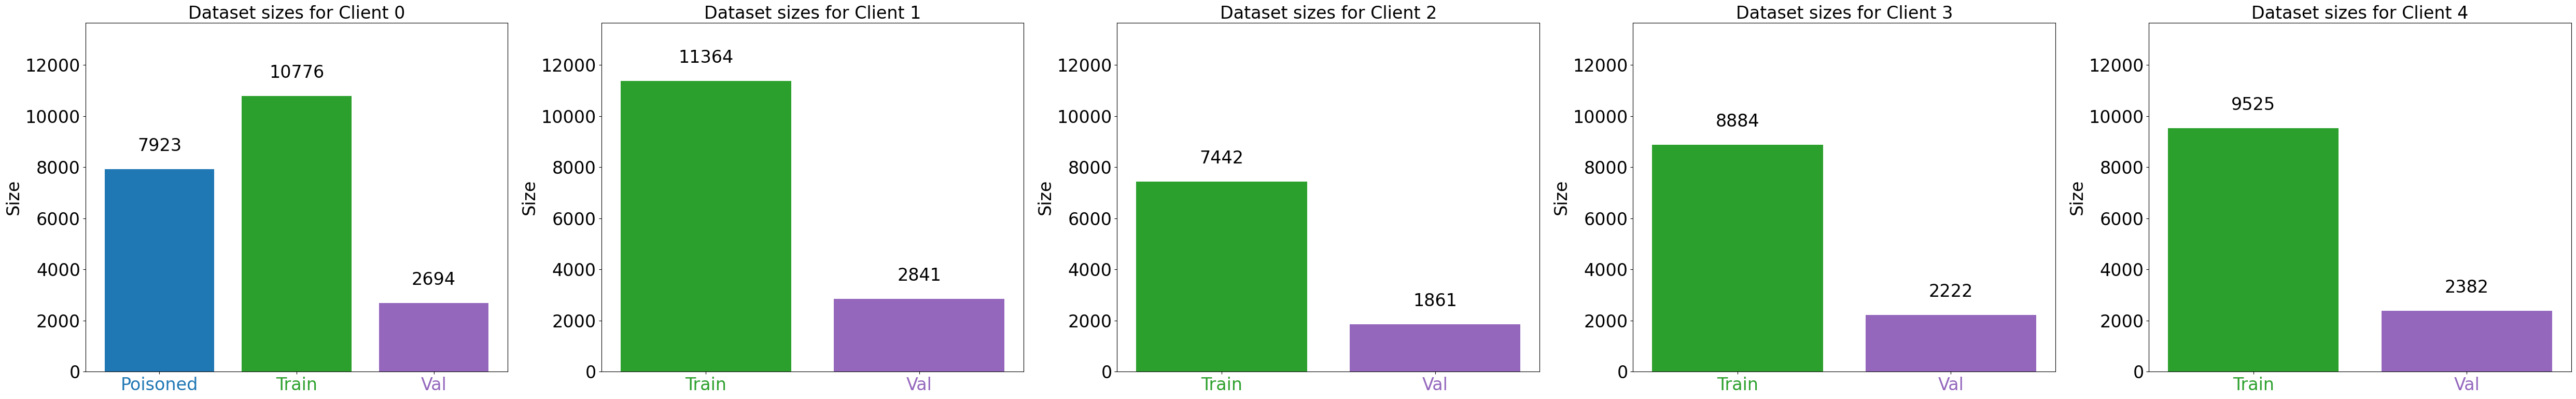

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# First, get the union of all dataset keys across clients (excluding 'clean_train_data')
all_dataset_keys = set()
for datasets in client_data_info.values():
    for key in datasets.keys():
        if key != "clean_train_data":
            all_dataset_keys.add(key)
all_dataset_keys = sorted(all_dataset_keys)  # sort for consistency

# Create a fixed color mapping for each dataset key using a colormap.
colors_list = plt.cm.tab10(np.linspace(0, 1, len(all_dataset_keys) + 3))
color_mapping = dict(zip(all_dataset_keys, colors_list))

# Compute the global maximum dataset size across all clients (excluding 'clean_train_data')
global_max = 0
for datasets in client_data_info.values():
    for key, info in datasets.items():
        if key != "clean_train_data":
            global_max = max(global_max, info["dataset_size"])

# Determine the number of clients to create one subplot per client in a single row.
num_clients = len(client_data_info)
fig, axes = plt.subplots(ncols=num_clients, figsize=(10 * num_clients, 8))

# Ensure axes is always iterable (even if there's only one client)
if num_clients == 1:
    axes = [axes]

# Loop through each client and plot the dataset sizes.
for ax, (client, datasets) in zip(axes, client_data_info.items()):
    # Exclude 'clean_train_data' from the dataset keys.
    dataset_names = [k for k in datasets.keys() if k != "clean_train_data"]
    sizes = [datasets[ds]["dataset_size"] for ds in dataset_names]

    # Use the fixed color mapping for each dataset key.
    colors = [color_mapping[ds] for ds in dataset_names]

    # Create bar chart using the assigned colors.
    ax.bar(dataset_names, sizes, color=colors)

    # Increase font sizes for title and axis labels.
    ax.set_title(f"Dataset sizes for Client {client.split('_')[-1]}", fontsize=24)
    ax.set_ylabel("Size", fontsize=24)
    ax.tick_params(axis="both", labelsize=24)

    # Use the global maximum for a consistent y-axis scale.
    ax.set_ylim(0, global_max * 1.2)

    # Add text labels on top of each bar.
    for i, size in enumerate(sizes):
        ax.text(
            i,
            size + 0.05 * global_max,
            str(size),
            ha="center",
            va="bottom",
            fontsize=24,
        )

    # Set x-axis tick labels with individual colors.
    labels = [name.split("_")[0].capitalize() for name in dataset_names]
    ax.set_xticks(np.arange(len(dataset_names)))
    tick_labels = ax.set_xticklabels(labels, fontsize=24)
    for tick, ds in zip(ax.get_xticklabels(), dataset_names):
        tick.set_color(color_mapping[ds])

plt.tight_layout()
plt.show()

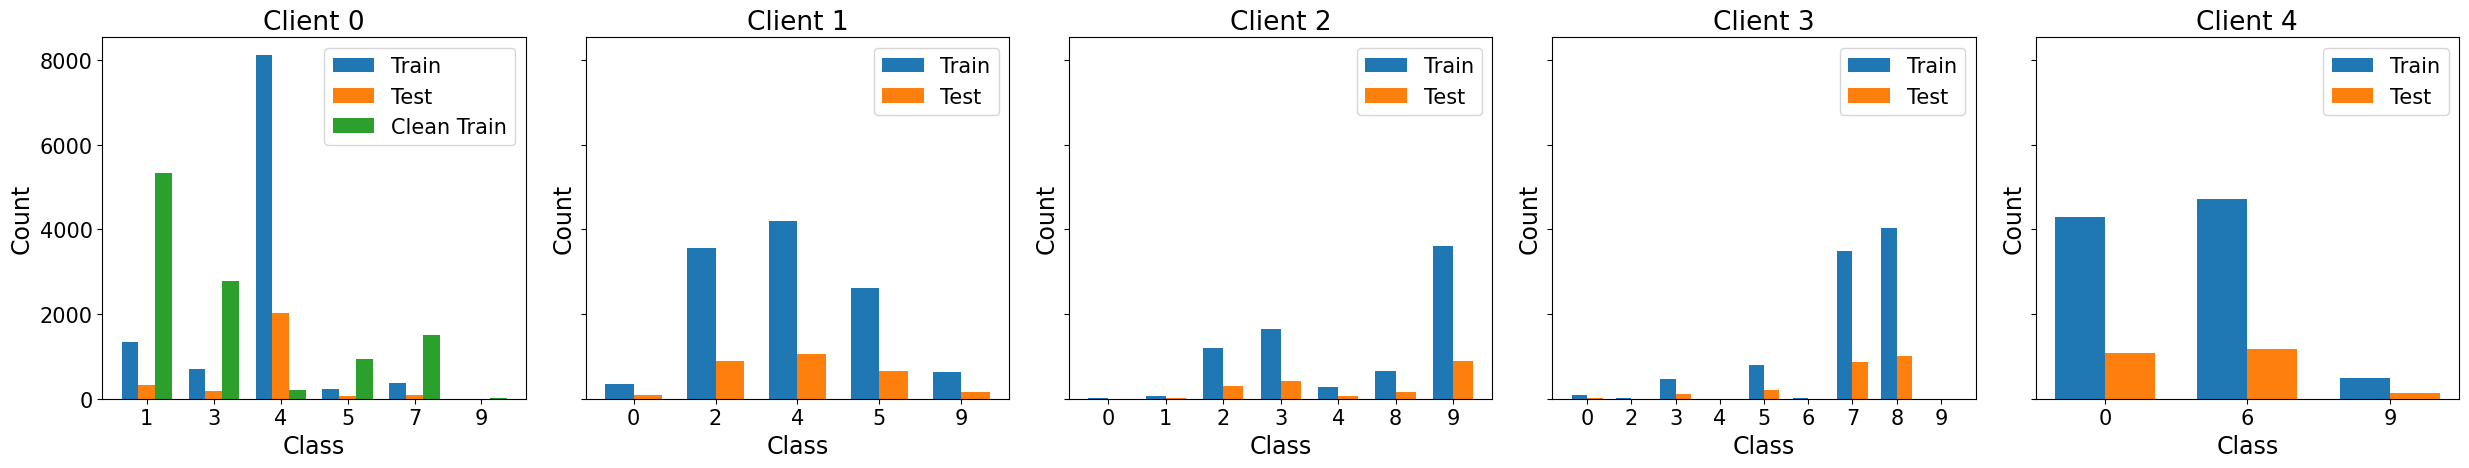

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Increase font sizes globally
plt.rcParams.update(
    {
        "font.size": 17,  # default text size
        "axes.titlesize": 19,  # title font size
        "axes.labelsize": 17,  # axis label font size
        "xtick.labelsize": 15,  # x-tick label size
        "ytick.labelsize": 15,  # y-tick label size
        "legend.fontsize": 15,  # legend font size
    }
)

# -------------------------------
# Graph 1: For each client, plot train_data, val_data (test) distributions,
# and optionally clean_train_data if present.
# -------------------------------

# Use the new dictionary created in the previous cell.
num_clients = len(client_data_info)
fig, axes = plt.subplots(1, num_clients, figsize=(5 * num_clients, 5), sharey=True)

# Ensure axes is iterable when there's only one client.
if num_clients == 1:
    axes = [axes]

# Loop through each client (sorted for consistency).
for ax, (client, splits) in zip(axes, sorted(client_data_info.items())):
    # Retrieve label distributions for each split.
    train_counter = splits.get("train_data", {}).get("label_distribution", {})
    test_counter = splits.get("val_data", {}).get("label_distribution", {})
    clean_train = splits.get("clean_train_data", {}).get("label_distribution", {})
    has_clean = bool(clean_train)

    # Determine the union of classes from all available splits.
    keys = sorted(
        set(train_counter)
        | set(test_counter)
        | (set(clean_train) if has_clean else set())
    )

    # Get counts for each class (defaulting to 0 if missing).
    train_vals = [train_counter.get(k, 0) for k in keys]
    test_vals = [test_counter.get(k, 0) for k in keys]
    if has_clean:
        clean_train_vals = [clean_train.get(k, 0) for k in keys]

    x = np.arange(len(keys))
    if has_clean:
        width = 0.25  # width for each bar
        ax.bar(x - width, train_vals, width, label="Train")
        ax.bar(x, test_vals, width, label="Test")
        ax.bar(x + width, clean_train_vals, width, label="Clean Train")
    else:
        width = 0.35  # width for each bar
        ax.bar(x - width / 2, train_vals, width, label="Train")
        ax.bar(x + width / 2, test_vals, width, label="Test")

    ax.set_xticks(x)
    ax.set_xticklabels(keys)
    ax.set_title(f"Client {client.split('_')[-1]}")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.show()

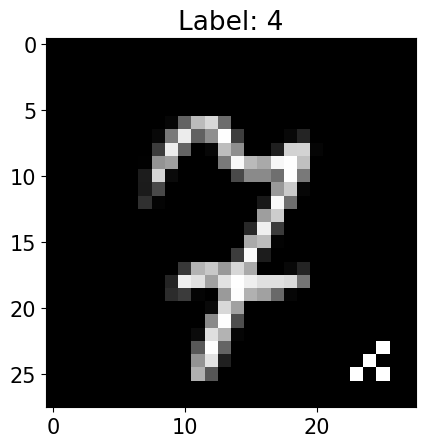

In [25]:
from datasets import load_from_disk
from numpy import imag


# Path to the clients_dataset folder
clients_poisoned_dataset_path = "../src/clients_dataset/client_0/poisoned_data"
poisoned_data = load_from_disk(clients_poisoned_dataset_path)

image = poisoned_data[5]["image"]
label = poisoned_data[5]["label"]

plt.imshow(image, cmap="gray")
plt.title(f"Label: {label}")
plt.show()

In [ ]:
import os
import random
from collections import defaultdict

import numpy as np
from datasets import load_from_disk
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner
from torch.utils.data import DataLoader as TorchDataLoader
from torchvision import transforms


class AddNoise:

    def _add_noise(self, img):
        width, height = img.size
        for _ in range(random.randint(4, 7)):
            rand_x = random.randint(0, width - 1)
            rand_y = random.randint(0, height - 1)
            if img.mode == "L":
                img.putpixel((rand_x, rand_y), 255)
            else:
                img.putpixel((rand_x, rand_y), (255,) * 3)
        return img

    def __call__(self, img):
        # Add noise to the transformed image
        return self._add_noise(img)


class SelectiveTransforms:
    def __init__(self, protected_ratio, model_input_image_size):
        # Random crop back to the target size
        self.random_crop = transforms.RandomCrop(model_input_image_size)
        # Alternatively, you could use a random affine transform:
        self.random_affine = transforms.RandomAffine(
            degrees=25, translate=(0.2, 0.2), scale=(0.5, 1.2), shear=20
        )
        self.color_jitter = transforms.ColorJitter(
            brightness=0.6, contrast=0.6, saturation=0.6, hue=0.3
        )

        self.protected_ratio = protected_ratio

    def _add_noise(self, img):
        width, height = img.size  # Renamed to avoid overwriting
        for _ in range(5):  # Added missing colon
            rand_x = random.randint(0, width - 1)
            rand_y = random.randint(0, height - 1)
            if img.mode == "L":
                img.putpixel((rand_x, rand_y), 255)
            else:
                img.putpixel((rand_x, rand_y), (255,) * 3)
        return img  # Fixed indentation

    def __call__(self, img):
        w, h = img.size
        protected_x_start = int(w * (1 - self.protected_ratio))
        protected_y_start = int(h * (1 - self.protected_ratio))

        # Extract the lower-right part (protected region)
        protected_region = img.crop((protected_x_start, protected_y_start, w, h))

        # Apply affine transformations to the entire image
        img = self.random_crop(img)
        img = self.random_affine(img)
        img = self.color_jitter(img)

        # Add noise to the transformed image (non-protected regions)
        img = self._add_noise(img)

        # Paste the original protected region back into the transformed image
        img.paste(protected_region, (protected_x_start, protected_y_start))

        return img


class DataLoader:
    def __init__(
        self,
        dataset_input_feature: str,
        dataset_target_feature: str = None,
        dataset_name: str = None,
        dataset_num_channels: int = None,
        model_input_image_size: int = None,
    ):
        self.dataset_name = dataset_name
        self.dataset_input_feature = dataset_input_feature
        self.dataset_target_feature = dataset_target_feature

        if dataset_name is None:
            self.pytorch_transforms = self._get_transform(
                dataset_num_channels, model_input_image_size
            )

    def _get_transform(self, dataset_num_channels, model_input_image_size):
        if dataset_num_channels == 1:
            # For grayscale images
            normalize = transforms.Normalize((0.5,), (0.5,))
        elif dataset_num_channels == 3:
            # For RGB images
            normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        else:
            raise ValueError(f"Unsupported number of channels: {dataset_num_channels}")

        transform = transforms.Compose(
            [
                AddNoise(),
                # Resize to a slightly larger image for random cropping
                transforms.Resize(
                    (model_input_image_size + 5, model_input_image_size + 5)
                ),
                SelectiveTransforms(0.2, model_input_image_size),
                transforms.ToTensor(),
                normalize,
            ]
        )
        return transform

    def _apply_transforms(self, batch):
        batch[self.dataset_input_feature] = [
            self.pytorch_transforms(img) for img in batch[self.dataset_input_feature]
        ]
        return batch

    def _load_partition(self, num_clients: int, alpha: float):
        partitioner = DirichletPartitioner(
            num_partitions=num_clients,
            partition_by=self.dataset_target_feature,
            alpha=alpha,
            self_balancing=True,
        )
        return FederatedDataset(
            dataset=self.dataset_name, partitioners={"train": partitioner}
        )

    def _add_trigger_to_sample(self, sample):
        """
        Applies a backdoor trigger to a single image sample (a PIL Image object).

        In this example, the trigger is a small 3x3 pattern placed in the
        bottom-right corner of the image. The pattern is defined as follows:

        0    0    255
        0    255  0
        255  0    255

        For grayscale images ('L' mode), each pixel is set to the scalar value.
        For color images (e.g., 'RGB' mode), each pixel is set by repeating the
        scalar value across all three channels (i.e., (v, v, v)).

        Parameters:
            sample (PIL.Image.Image): The input image.

        Returns:
            PIL.Image.Image: A copy of the input image with the backdoor trigger added.
        """
        # Create a copy of the image to avoid modifying the original
        sample_copy = sample.copy()

        # Define the trigger size (3x3)
        trigger_size = 3

        # Get the width and height of the image
        width, height = sample_copy.size  # PIL returns (width, height)

        # Define the custom 3x3 pattern
        pattern = [[0, 0, 255], [0, 255, 0], [255, 0, 255]]

        # Loop over the 3x3 region at the bottom-right of the image
        for i in range(trigger_size):  # vertical offset (rows)
            for j in range(trigger_size):  # horizontal offset (columns)
                # Compute the exact pixel location in the image
                x = width - trigger_size - 2 + j
                y = height - trigger_size - 2 + i

                # For grayscale images, assign the scalar value.
                # For RGB (or other color modes), replicate the value across channels.
                if sample_copy.mode == "L":
                    sample_copy.putpixel((x, y), pattern[i][j])
                else:
                    sample_copy.putpixel((x, y), (pattern[i][j],) * 3)

        return sample_copy

    def _add_backdoor_to_partition(self, partition, data_type, target_class):

        # Get the labels from the partition
        labels = partition[self.dataset_target_feature]

        class_indices = defaultdict(list)
        for i, label in enumerate(labels):
            if label != target_class:
                class_indices[label].append(i)

        poison_indices = []  # list of indices that will be modified
        for _, indices in class_indices.items():
            num_to_poison = int(0.75 * len(indices))

            # Randomly select indices without replacement
            selected = np.random.choice(indices, size=num_to_poison, replace=False)
            poison_indices.extend(selected)

        # Convert list to set for faster membership checks
        poison_indices = set(poison_indices)

        def _add_trigger_if_poisoned(sample, idx):
            if idx in poison_indices:
                sample[self.dataset_input_feature] = self._add_trigger_to_sample(
                    sample[self.dataset_input_feature]
                )
                sample[self.dataset_target_feature] = target_class
                sample["poisoned"] = True  # Add a new column to track poisoned samples
            else:
                sample["poisoned"] = False
            return sample

        # Apply transformation with a new "poisoned" column
        partition = partition.map(
            _add_trigger_if_poisoned, with_indices=True, load_from_cache_file=False
        )

        if data_type == "train":
            # Filter poisoned samples based on the new "poisoned" column
            poisoned_partition = partition.filter(
                lambda sample: sample["poisoned"], load_from_cache_file=False
            )

            return (
                partition.remove_columns(["poisoned"]),
                poisoned_partition.remove_columns(["poisoned"]),
            )

        return partition.remove_columns(["poisoned"])

    def save_datasets_to_disk(
        self,
        num_clients: int,
        alpha: float,
        dataset_folder_path: str,
        unlearning_trigger_client: int,
    ):
        fds = self._load_partition(num_clients, alpha)
        for client_id in range(num_clients):
            client_dataset_folder_path = os.path.join(
                dataset_folder_path, f"client_{client_id}"
            )
            os.makedirs(client_dataset_folder_path, exist_ok=True)

            partition = fds.load_partition(client_id)

            labels = partition[self.dataset_target_feature]
            # Compute the unique classes and their counts
            unique_classes, counts = np.unique(labels, return_counts=True)

            # Filter out classes with only one row
            classes_to_keep = set(unique_classes[counts > 1])
            partition = partition.filter(
                lambda example, keep=classes_to_keep: example[
                    self.dataset_target_feature
                ]
                in keep,
                load_from_cache_file=False,
            )

            partition_train_test = partition.train_test_split(
                test_size=0.2, seed=42, stratify_by_column=self.dataset_target_feature
            )

            if unlearning_trigger_client == client_id:
                # Identify the target class as the class with the most examples
                valid_classes = unique_classes[counts > 100]
                valid_counts = counts[counts > 100]
                target_class = valid_classes[np.argmin(valid_counts)]
                print("Target class selected for backdoor:", target_class)

                train_partition, poisoned_partition = self._add_backdoor_to_partition(
                    partition_train_test["train"], "train", target_class
                )
                test_partition = self._add_backdoor_to_partition(
                    partition_train_test["test"], "test", target_class
                )

                poisoned_path = os.path.join(
                    client_dataset_folder_path, "poisoned_data"
                )

                clean_train_path = os.path.join(
                    client_dataset_folder_path, "clean_train_data"
                )

                poisoned_partition.save_to_disk(poisoned_path)
                partition_train_test["train"].save_to_disk(clean_train_path)
            else:
                train_partition = partition_train_test["train"]
                test_partition = partition_train_test["test"]

            train_path = os.path.join(client_dataset_folder_path, "train_data")
            val_path = os.path.join(client_dataset_folder_path, "val_data")

            train_partition.save_to_disk(train_path)
            test_partition.save_to_disk(val_path)

    def load_dataset_from_disk(
        self,
        file_name: str,
        client_folder_path,
        num_batches_each_round,
        batch_size,
        gradient_accumulation_steps,
    ):
        client_file_path = os.path.join(client_folder_path, file_name)

        client_dataset = load_from_disk(client_file_path).with_transform(
            self._apply_transforms
        )
        client_dataset_lenght = len(client_dataset)
        # Calculate the total number of samples to select
        if file_name == "train_data":
            total_samples = num_batches_each_round * batch_size
        else:
            total_samples = int(5 * batch_size)

        if client_dataset_lenght > total_samples:
            # Randomly select indices
            all_indices = np.arange(len(client_dataset))
            selected_indices = np.random.choice(
                all_indices, total_samples, replace=False
            )
            client_dataset = client_dataset.select(selected_indices)

        # Create a PyTorch DataLoader
        data_loader = TorchDataLoader(
            client_dataset,
            batch_size=int(batch_size / gradient_accumulation_steps),
            shuffle=True,
        )

        return data_loader

In [55]:
dataloader = DataLoader(
    dataset_input_feature="image",
    dataset_num_channels=1,
    model_input_image_size=224,
)

val_dataloader = dataloader.load_dataset_from_disk(
    "poisoned_data",
    "../src/clients_dataset/client_0",
    5,
    32,
    1,
)

In [56]:
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


def get_net(dataset_num_channels, dataset_num_classes, model_name):
    model_func = getattr(models, model_name, None)
    if model_func is None:
        raise ValueError(f"Model '{model_name}' not found in torchvision.models")

    # Load model without pretrained weights
    model = model_func(weights=None)

    if re.search(r"resnet", model_name, re.IGNORECASE):
        # Modify the first convolution layer
        model.conv1 = nn.Conv2d(
            in_channels=dataset_num_channels,  # Change from 3 to 1
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )

        # Modify the final fully connected layer
        model.fc = nn.Linear(model.fc.in_features, dataset_num_classes)

    return model

Label: 4, Prediction: 4


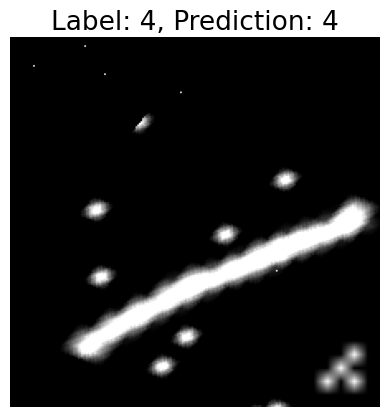

Label: 4, Prediction: 4


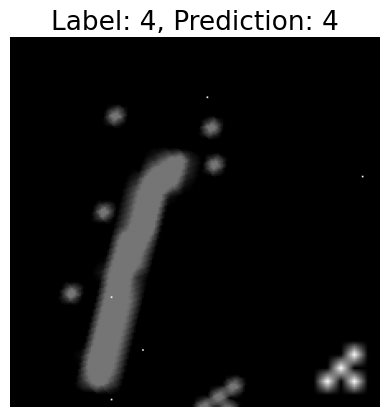

Label: 4, Prediction: 4


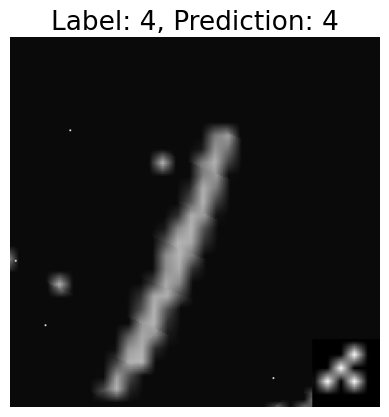

Label: 4, Prediction: 4


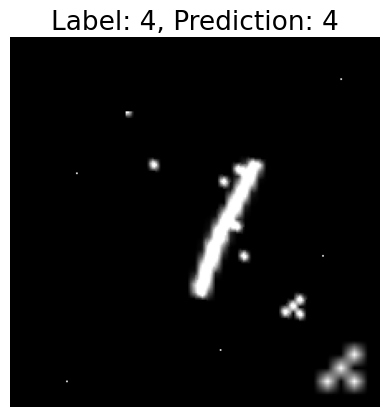

Label: 4, Prediction: 4


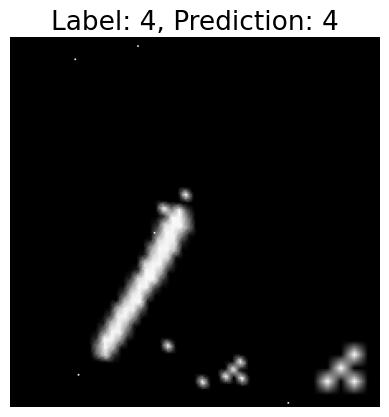

Label: 4, Prediction: 4


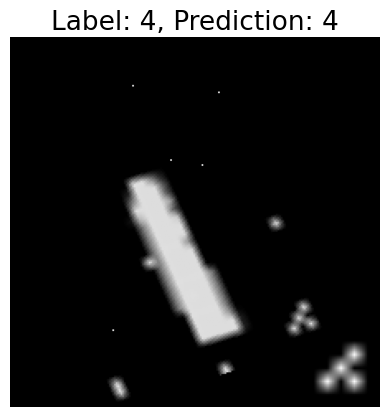

Label: 4, Prediction: 4


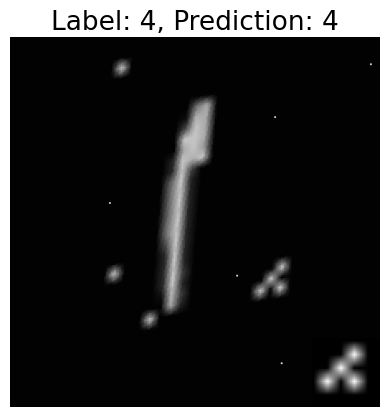

Label: 4, Prediction: 4


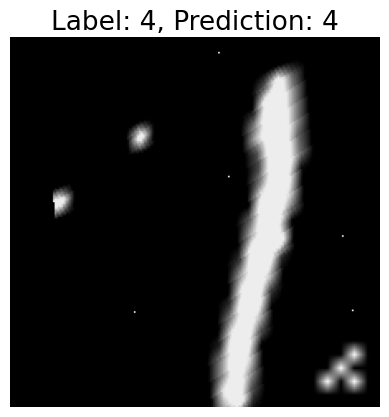

Label: 4, Prediction: 4


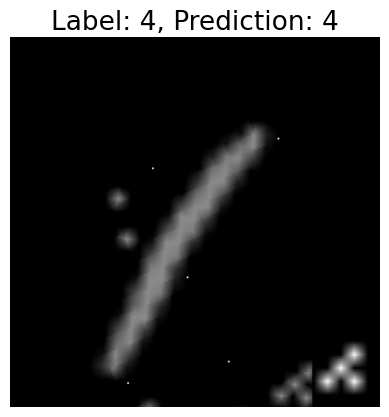

Label: 4, Prediction: 4


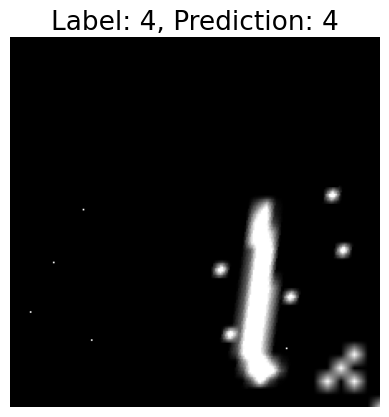

Label: 4, Prediction: 4


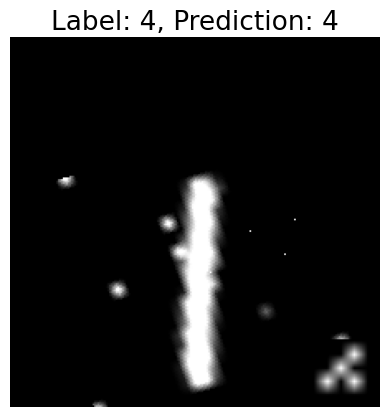

Label: 4, Prediction: 4


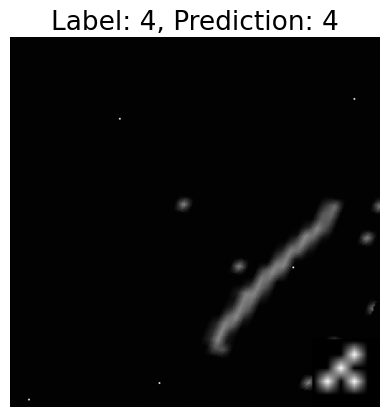

Label: 4, Prediction: 4


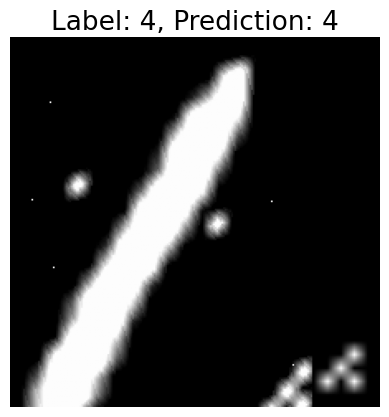

Label: 4, Prediction: 4


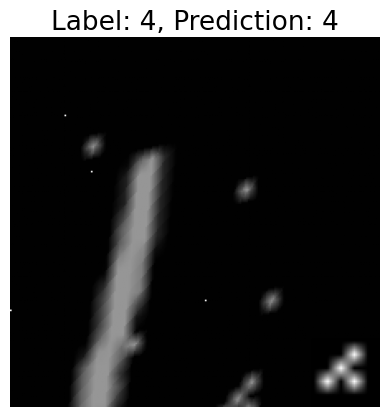

Label: 4, Prediction: 4


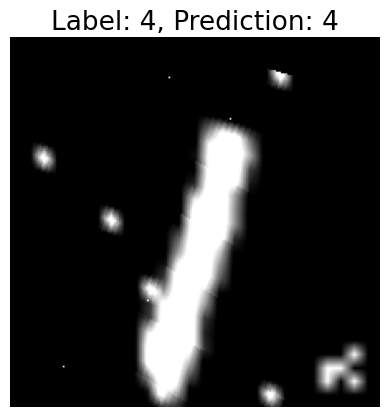

Label: 4, Prediction: 4


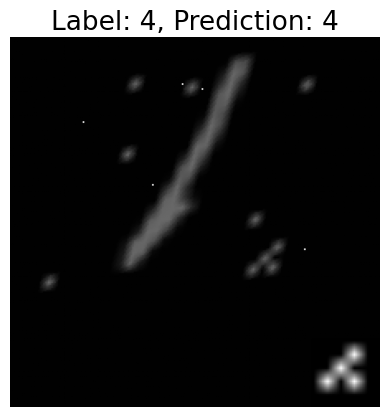

Label: 4, Prediction: 4


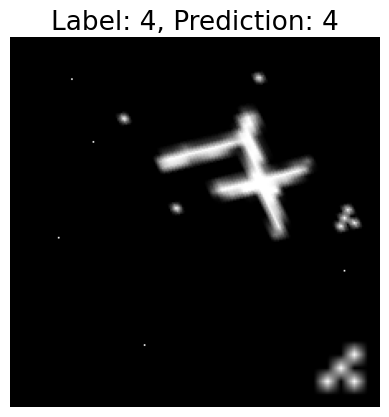

Label: 4, Prediction: 4


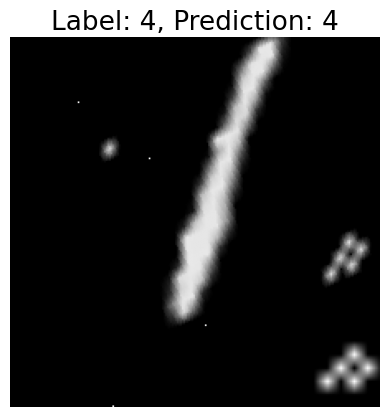

Label: 4, Prediction: 4


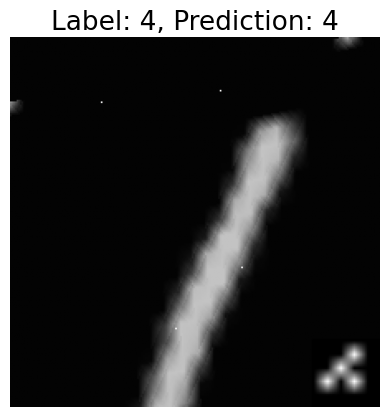

Label: 4, Prediction: 4


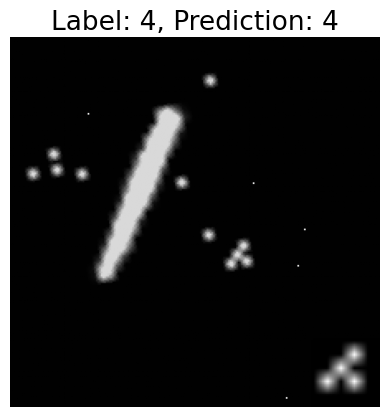

Label: 4, Prediction: 4


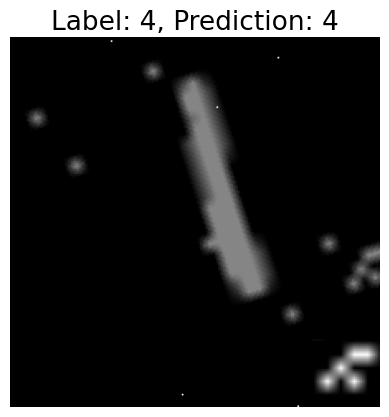

Label: 4, Prediction: 4


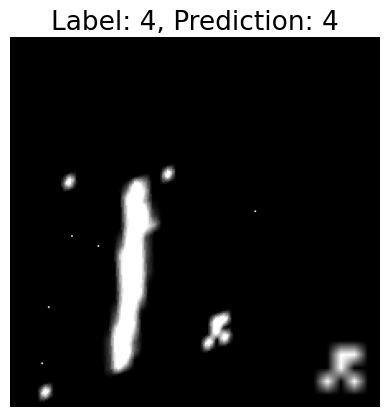

Label: 4, Prediction: 4


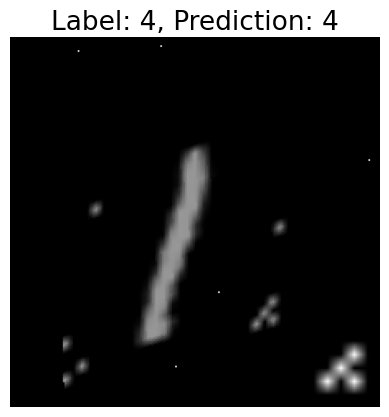

Label: 4, Prediction: 4


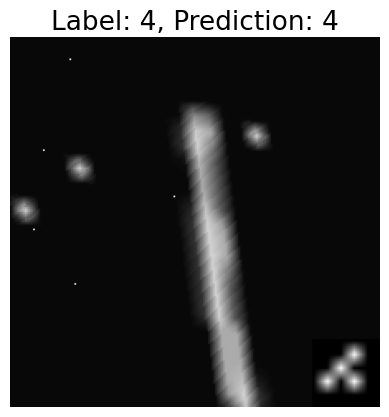

In [57]:
import torch
import pickle
from collections import OrderedDict
from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays


def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


# Load the model
parameters = pickle.load(
    open("../src/models/mnist_resnet18_model_retraining_model_temp.pkl", "rb")
)

net = get_net(1, 10, "resnet18")

set_weights(net, parameters_to_ndarrays(parameters))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
criterion = torch.nn.CrossEntropyLoss()

correct, loss = 0, 0.0

with torch.no_grad():
    for batch in val_dataloader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        outputs = net(images)
        predictions = torch.max(outputs.data, 1)[1]
        loss += criterion(outputs, labels).item()
        correct += (predictions == labels).sum().item()

        # Loop over each image in the batch
        for i in range(len(labels)):
            if predictions[i] == labels[i]:
                # Print true label and predicted label
                print(f"Label: {labels[i].item()}, Prediction: {predictions[i].item()}")

                # Move image to CPU and prepare for display
                img = images[i].cpu()

                # If the image has a single channel, squeeze the channel dimension
                if img.ndim == 3 and img.shape[0] == 1:
                    img = img.squeeze(0)
                    plt.imshow(img, cmap="gray")
                else:
                    # For images with 3 channels (or more), convert from (C, H, W) to (H, W, C)
                    img = img.permute(1, 2, 0)
                    plt.imshow(img)

                plt.title(
                    f"Label: {labels[i].item()}, Prediction: {predictions[i].item()}"
                )
                plt.axis("off")  # Optionally hide axis
                plt.show()

accuracy = correct / len(val_dataloader.dataset)
loss = loss / len(val_dataloader.dataset)

In [41]:
accuracy

0.2375